In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor
from scipy.optimize import least_squares
import math
from photonic_hamiltonian.inference import io_data
#load an example data file, data courtersy: Fan Du
real_data = io_data.load_data('photonic_hamiltonian\data\expdata_GM0p065.nc')

In [2]:
# infer ex delta
from pytensor import tensor as pt
import numpy as np
import pymc as pm
import pytensor

def Hamiltonian_model(data,prior_bounds):
    """
    returns a pymc model to infer the parameters for a four-basis Hamiltonian.
    The piors on all parameters ~ Uniform(given lower, given upper)
    The likelihood ~ Gaussian(line, sigma_y)
    Line is the expectation value obtained by taking the sum of background and 4 Gaussian peaked
    at the eigenvalues of 4x4 Hamiltonian matrix
    
    Parameters:
        data: the data set of a single-momentum spectrum 
              (DataArray with 'x': frequency, 'y': intensity, and 'sigma_y': intensity uncertainty)
        prior_bounds: the bounds for uniform priors of all parameters we want to infer
              (dict mapping a string, name of the parameter, to a list of its bounds [lower, upper])
              
    Return:
        ham_model: the pymc model can be used to infer the parameters and their posterior
              (pymc Model object)
    
    """
    #extract data to numpy arrays
    freq = data['normf'].to_numpy()
    intensity = data['spectrum'].to_numpy()
    intensity_sig = data['spectrum_std'].to_numpy()
    kx = 0.05
    ky = 0
    #define likelihood function
    def likelihood(theta, y, x, sigma_y):
        """
        returns the loglike likelihood of our model
        
        Parameters:
            theta: the parameters in Hamiltonian matrix (list)
            y, x, sigma_y: our data (numpy arrays)
        
        Return:
            the loglike likelihood (float)
        """
        #for our four-basis Hamiltonian, the parameters include
        #interaction-between-modes terms u11, u20;
        #background A0 and heights of 4 peaks A1, A2, A3, A4
        #peak width (assumed to be the same for all peaks) sigma_L
        u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
        ex = e0+de   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
        ey = e0-de   # for k = (+-0.05,0) the energy of uncoupled slab mode 2
        ham = pytensor.shared(np.zeros((4,4)))
        #Hamiltonian matrix
        ham_np = np.array([[ex,u11,u20,u11],
                           [u11,ey,u11,u20],
                           [u20,u11,ey,u11],
                           [u11,u20,u11,ex]])
        
        for row in range(4):
            for col in range(4):
               
                ham = pt.set_subtensor(ham[row, col], ham_np[row, col])
        
        #peak heights and peak positions
        An_np = np.array([A1,A2,A3,A4])
        An = pytensor.shared(np.zeros(4))
        Wn_np = np.array([W1, W2, W3, W4])
        Wn = pytensor.shared(np.zeros(4))
        for col in range(4):
            An = pt.set_subtensor(An[col], An_np[col])
            Wn = pt.set_subtensor(Wn[col], Wn_np[col])

        Cn = pt.nlinalg.eigh(ham)[0]
        # make sure eigenvalues are sorted
        Cn = pt.sort(Cn)

        #expectation value as sum of 4 gaussian peaks and background
        #line = A0 + An[0] * pt.exp(-pt.sqr(x - Cn[0]) / (2 * pt.sqr(sigma_L))) + An[1] * pt.exp(-pt.sqr(x - Cn[1]) / (2 * pt.sqr(sigma_L))) + An[2] * pt.exp(-pt.sqr(x - Cn[2]) / (2 * pt.sqr(sigma_L))) + An[3] * pt.exp(-pt.sqr(x - Cn[3]) / (2 * pt.sqr(sigma_L)))
        #### lorentz = [(Ai * sigma_n**2)/((f - Ci)**2 + sigma_n**2) for Ai, Ci, sigma_n in zip(An, Cn,sigma_n)]
        line0 = An[0]*pt.sqr(Wn[0])/(pt.sqr(x-Cn[0])+pt.sqr(Wn[0])) + An[1]*pt.sqr(Wn[1])/(pt.sqr(x - Cn[1])+pt.sqr(Wn[1])) + An[2]*pt.sqr(Wn[2])/(pt.sqr(x - Cn[2])+pt.sqr(Wn[2]))+An[3]*pt.sqr(Wn[3])/(pt.sqr(x - Cn[3])+pt.sqr(Wn[3]))
        line = A0+line0
        return pt.sum(-(0.5 / pt.sqr(sigma_y)) * pt.sqr(y - line))
    
    #create the multi Gaussian peak model
    ham_model = pm.Model()
    with ham_model:
        # Priors for unknown model parameters
        theta_list = []
        for i in list(prior_bounds.keys()):
            #check if the lower bound is strictly smaller than the upper bound
            if prior_bounds[i][0] >= prior_bounds[i][1]:
                raise ValueError
            theta_list.append(pm.Uniform(i, lower=prior_bounds[i][0], upper=prior_bounds[i][1]))
    
        #input of our log-likelihood
        theta = pt.as_tensor_variable(theta_list)
    
        # Likelihood of observations
        pm.Potential("likelihood", likelihood(theta,intensity, freq, intensity_sig))

    return ham_model

def fit_curve(freq, theta):
    """
    Calculate the multi Gaussian peak curve fit using a set of given fitting parameters

    Parameters
    ----------
    freq (NumPy array):
        The array of normalized frequency (x data)
    theta (list):
        The list of fitting parameters, in the order u11, u20, A0, A1, A2, A3, A4, sigma_L
        
    Return
    ---------
    line (NumPy array):
        The array of corresponding fitted intensity
    """

    u11, u20, e0,de, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
    An = [A1, A2, A3, A4]
    Wn = [W1, W2, W3, W4]
    ex = e0+de   # for k = (0, +-0.05) the energy of uncoupled slab mode 1 
    ey = e0-de   # for k = (+-0.05,0) the energy of uncoupled slab mode 2

    #Hamiltonian matrix and its eigenvalues as line peaks
    H = [[ex,u11,u20,u11],
         [u11,ey,u11,u20],
         [u20,u11,ey,u11],
         [u11,u20,u11,ex]]
    Cn = np.real(np.linalg.eigvals(H))
    Cn = np.sort(Cn)
    
    #calculate normalized intensity
    line = [(Ai * Wi**2)/((freq- Ci)**2 + Wi**2) for Ai, Ci, Wi in zip(An, Cn, Wn)]
    
    #line_each = [Ai * np.exp(-(freq - Ci)**2 / (2 * sigma_L**2)) for Ai, Ci in zip(An, Cn)]
    line = np.sum(line, axis=0) + A0
    
    return line

Text(0.5, 1.0, 'Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

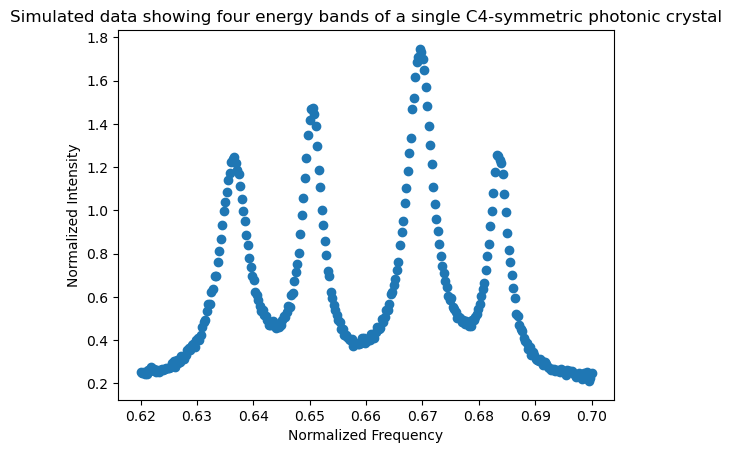

In [6]:
# Create simulated data
N = 300
simu_normf = np.linspace(0.62,0.70,N)    # create normalized frequency, "x" variable 

#set all hamiltonian parameters as some constants
u11 = 0.007
u20 = 1e-5
e0 = 0.66
de = 0.015
A0 = 0.2
A1 = 1
A2 = 1.2
A3 = 1.5
A4 = 1
[A1,A2,A3,A4] = [1,1.2,1.5,1]
#sigma_L = 0.002
[W1,W2,W3,W4] = [0.003,0.0021,0.0028,0.002]
theta = [u11, u20, e0,de, A0, A1, A2, A3, A4, W1,W2,W3,W4]

#create normalized intensity
line = fit_curve(simu_normf, theta)

#create noise
sigma_noise = 0.01
noise = np.random.normal(0, sigma_noise, N)

#create data array
simu_data = xr.Dataset(data_vars = {'spectrum': ('normf', line + noise),
                                  'spectrum_std': ('normf', [sigma_noise]*N)},
                     coords = { 'normf': simu_normf})

#plot the simulated data to visualize the four peaks
plt.errorbar(simu_normf, line + noise, sigma_noise, fmt='o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Simulated data showing four energy bands of a single C4-symmetric photonic crystal')

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]


Sampling 4 chains for 10 tune and 300 draw iterations (40 + 1_200 draws total) took 199 seconds.


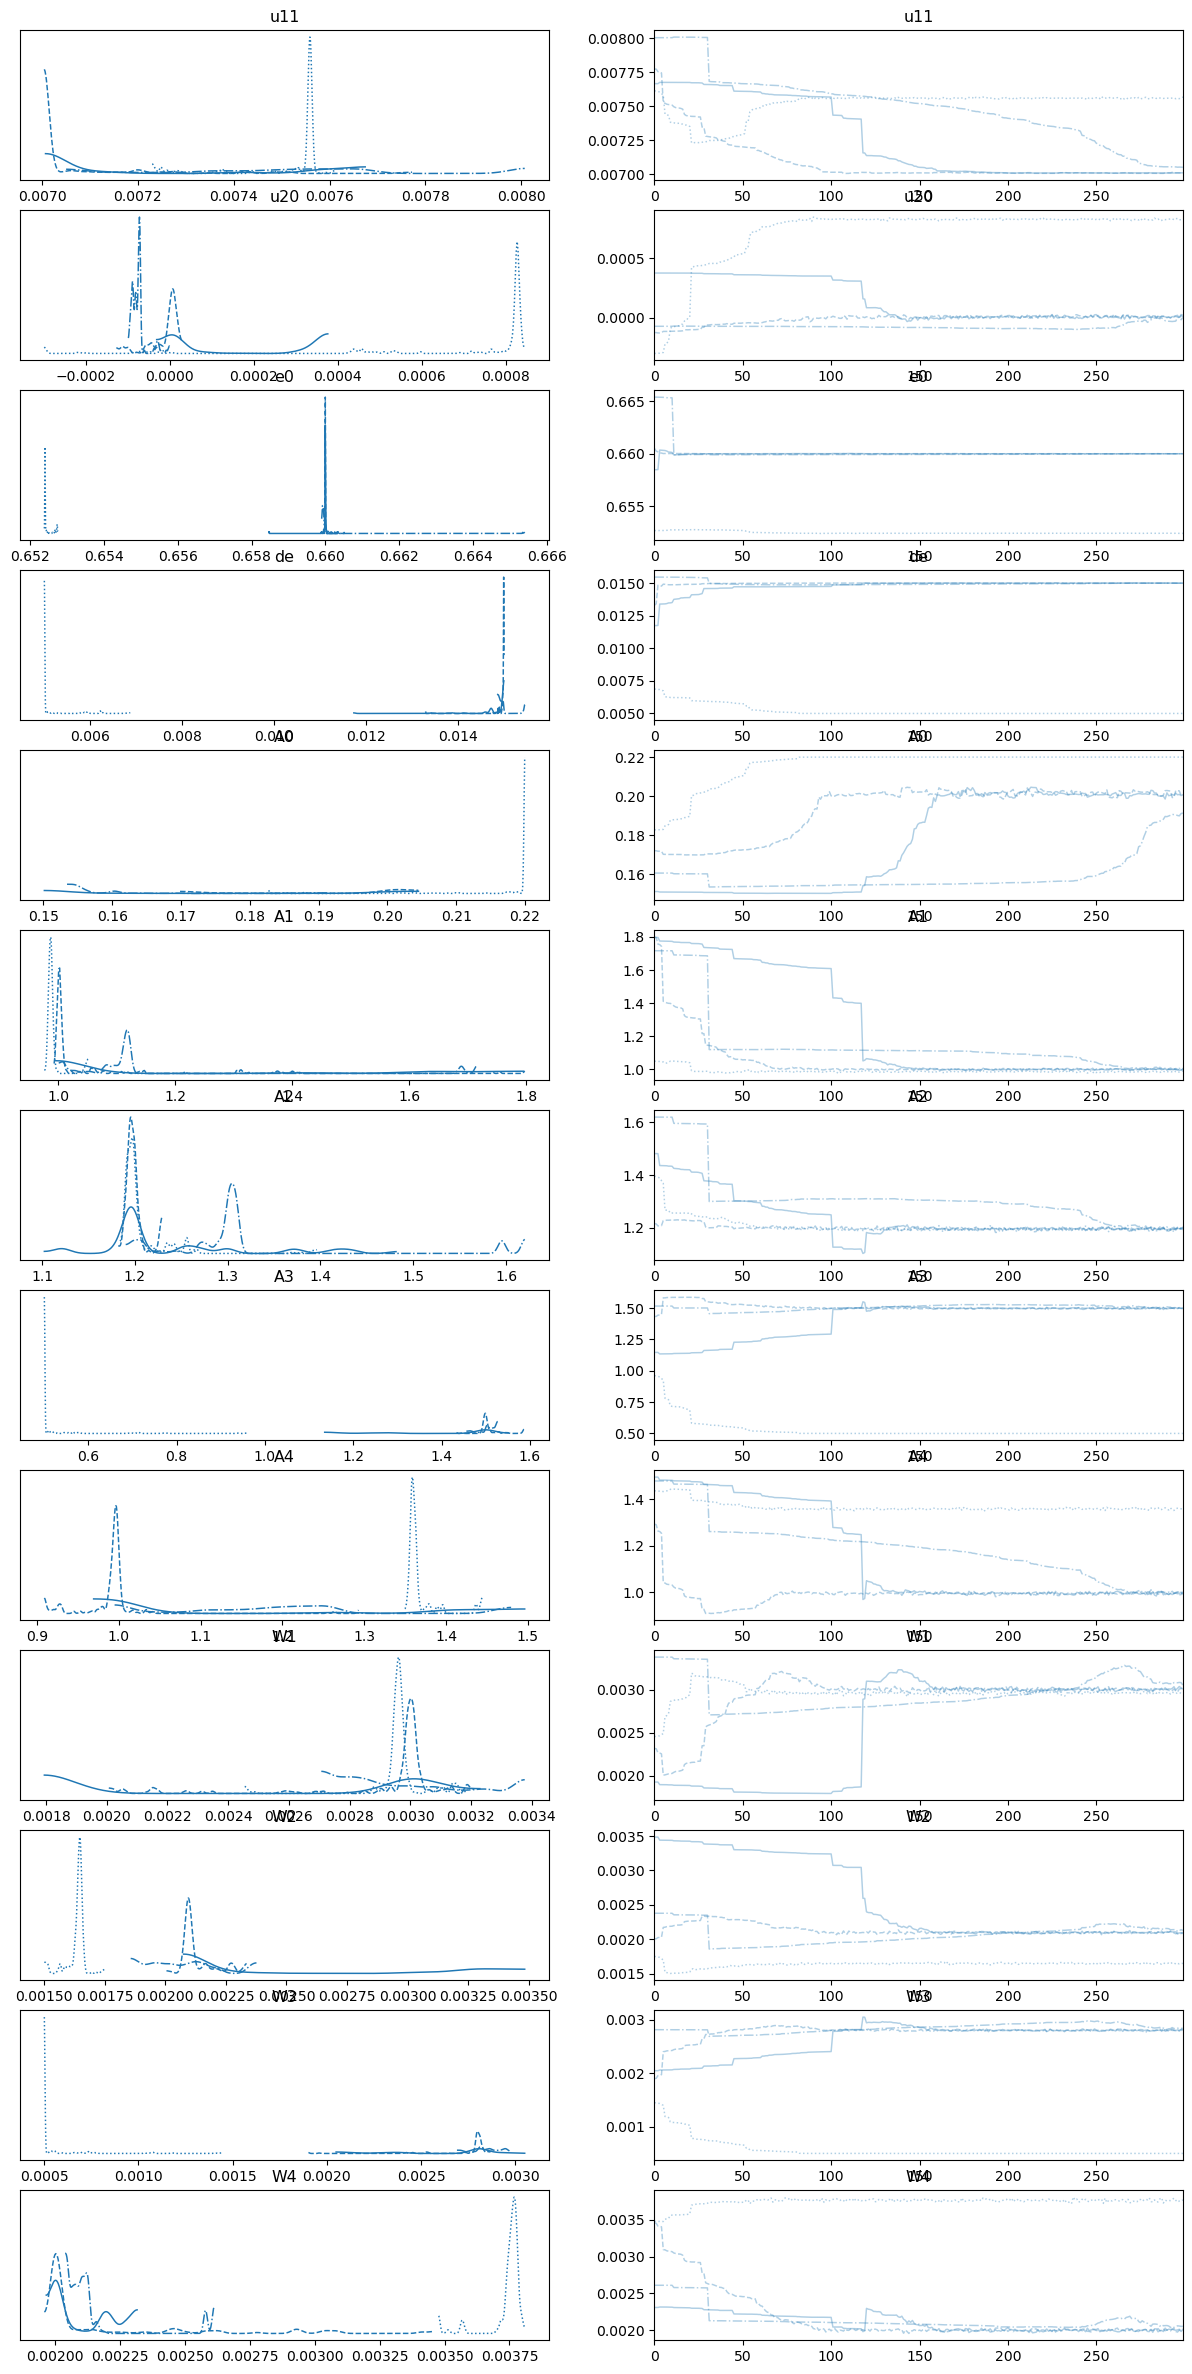

In [18]:
#guess the prior bounds
prior_W = [0.0005,0.005]
simu_prior_bounds = {'u11':[0.007, 0.009], 'u20':[-0.001, 0.001], 'e0':[0.64,0.68],'de':[0.005,0.02],
                     'A0':[0.1, 0.22], 'A1':[0.5, 2.5],'A2':[0.5, 2.5], 'A3':[0.5, 2.5], 'A4':[0.5, 2,5],
                     'W1':prior_W, 'W2':prior_W, 'W3':prior_W, 'W4':prior_W}

#create the model 
simu_ham_model = Hamiltonian_model(simu_data, simu_prior_bounds)
with simu_ham_model:
    simu_idata = pm.sample(300, tune=10)

az.plot_trace(simu_idata, figsize=(15,30));

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u11,0.007338,0.000276,0.007004,0.007671,0.000119,0.000090,5.535639,20.536281,2.006117
u20,0.000195,0.000349,-0.000093,0.000835,0.000161,0.000123,5.748998,25.585151,2.138107
e0,0.658147,0.003323,0.652401,0.660010,0.001622,0.001237,5.876969,28.512625,1.872990
de,0.012480,0.004214,0.005000,0.014996,0.002074,0.001585,5.638616,22.380367,2.028919
A0,0.186228,0.025874,0.150584,0.219998,0.012160,0.009222,4.904584,19.676371,2.518651
A1,1.113066,0.223305,0.980019,1.689733,0.086454,0.064023,5.307688,20.908543,2.117896
A2,1.238854,0.082474,1.176537,1.411377,0.028551,0.020939,8.842128,26.853457,1.473704
A3,1.236625,0.419557,0.500007,1.527373,0.204706,0.156190,5.476155,20.564234,2.111908
A4,1.177726,0.181978,0.986732,1.480570,0.081544,0.061421,5.797177,20.031231,1.868873
W1,0.002847,0.000381,0.001793,0.003188,0.000143,0.000105,17.080861,19.868804,1.656085


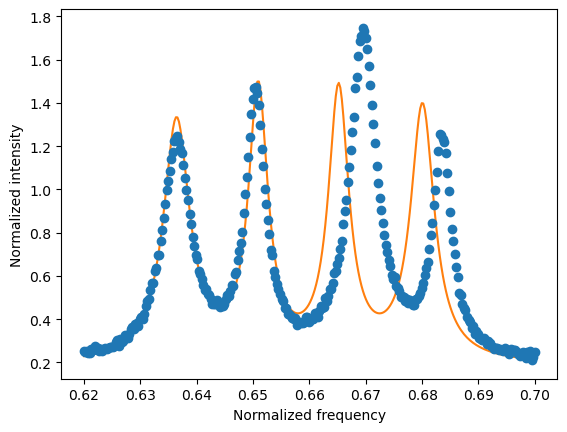

In [20]:
#summary the fitting results
simu_summary = az.summary(simu_idata,round_to=8)
display(simu_summary)

#plot data with the fitting curve
u11, u20,e0,de, A0, A1, A2, A3, A4, W1,W2,W3,W4 = simu_summary['mean'].values
simu_theta = [u11, u20, e0,de, A0, A1, A2, A3, A4, W1, W2, W3, W4 ]
model_predictions = fit_curve(simu_normf, simu_theta)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.errorbar(simu_normf, line + noise, sigma_noise, fmt = 'o')
plt.plot(simu_normf, model_predictions);

Text(0.5, 1.0, 'Example data showing four energy bands of a single C4-symmetric photonic crystal')

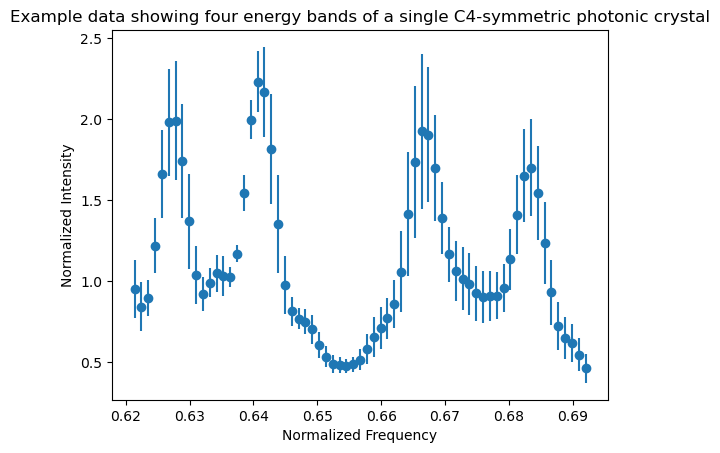

In [9]:
freq = real_data['normf'].to_numpy()
intensity = real_data['spectrum'].to_numpy()
intensity_sig = real_data['spectrum_std'].to_numpy()
plt.errorbar(freq, intensity, intensity_sig,fmt='o')
plt.xlabel('Normalized Frequency')
plt.ylabel('Normalized Intensity')
plt.title('Example data showing four energy bands of a single C4-symmetric photonic crystal')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [u11, u20, e0, de, A0, A1, A2, A3, A4, W1, W2, W3, W4]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 111 seconds.


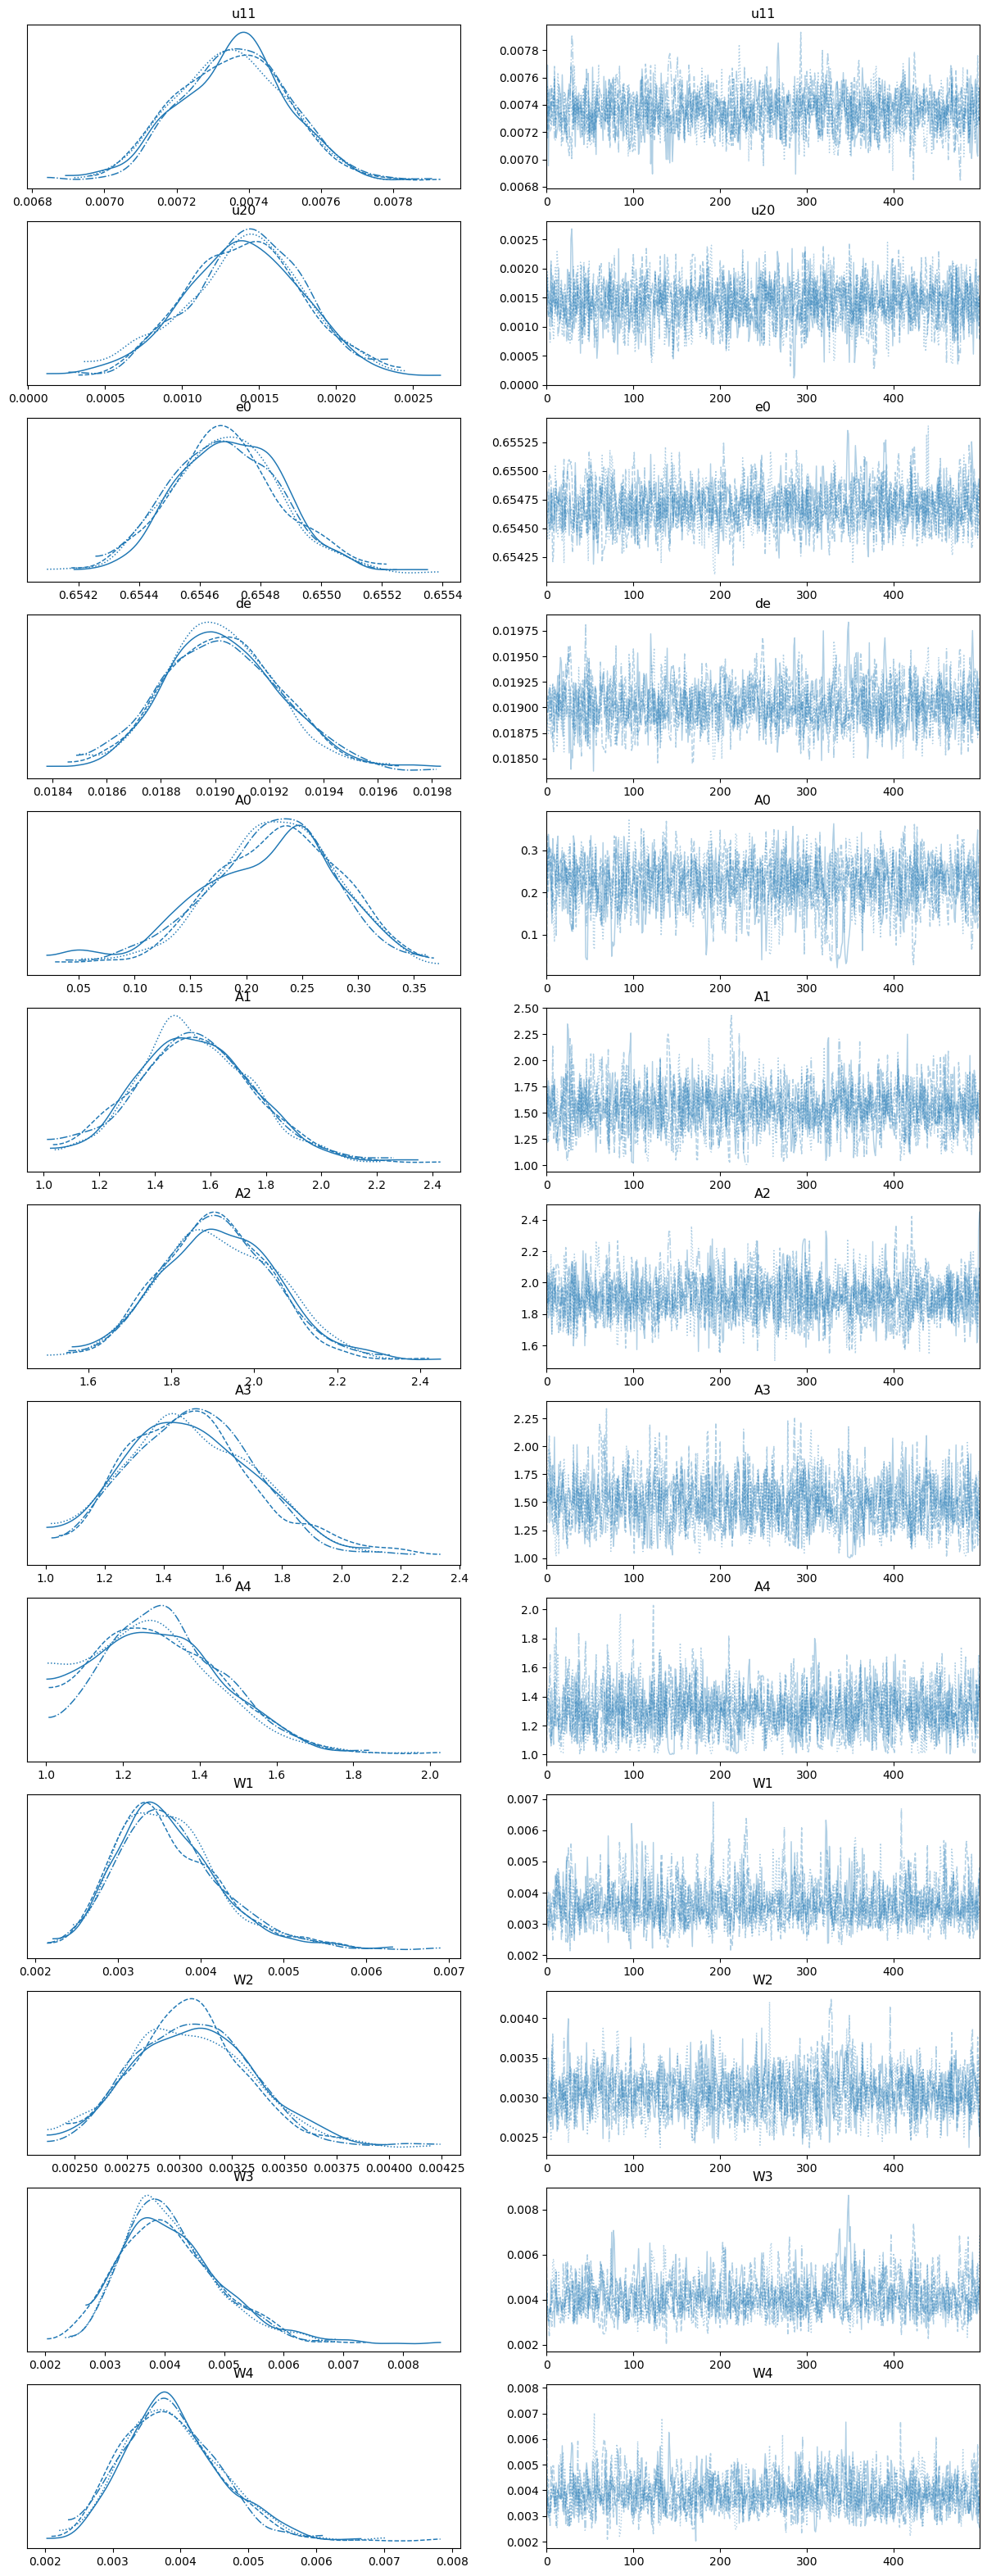

In [10]:
#guess the prior bounds
# u11, u20, neff, ratio, A0, A1, A2, A3, A4, W1, W2, W3, W4 = theta
prior_W = [0.001,0.03]

simu_prior_bounds = {'u11':[0.005, 0.01], 'u20':[0, 0.005], 'e0':[0.64,0.67],'de':[0.005,0.025],
                     'A0':[0, 1], 'A1':[1, 2.5],'A2':[1, 2.5], 'A3':[1, 2.5], 'A4':[1, 2.5],
                     'W1':prior_W, 'W2':prior_W, 'W3':prior_W, 'W4':prior_W}

#create the model 
simu_ham_model = Hamiltonian_model(real_data,simu_prior_bounds)
with simu_ham_model:
    simu_idata = pm.sample(500)

az.plot_trace(simu_idata, figsize=(15,40));

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
u11,0.007357,0.000151,0.007090,0.007644,0.000004,0.000003,1494.377816,1140.156310,1.002116
u20,0.001408,0.000384,0.000655,0.002095,0.000009,0.000007,1661.116762,1398.493046,0.999696
e0,0.654691,0.000186,0.654347,0.655044,0.000005,0.000004,1214.878279,1179.072376,1.002016
de,0.019026,0.000217,0.018621,0.019434,0.000006,0.000005,1164.461467,1253.021384,1.000784
A0,0.221823,0.059540,0.110511,0.330953,0.001922,0.001359,1148.683730,566.592507,1.004351
A1,1.544356,0.221081,1.127405,1.970973,0.005520,0.003904,1541.324266,1097.401095,1.000974
A2,1.911083,0.138944,1.632133,2.149593,0.003255,0.002331,1846.258783,1173.843862,1.001855
A3,1.495140,0.220701,1.083461,1.888886,0.006497,0.004595,1084.655664,906.403493,1.001647
A4,1.294323,0.162171,1.002524,1.564735,0.004102,0.002901,1325.571150,665.625237,1.002332
W1,0.003631,0.000661,0.002503,0.004864,0.000018,0.000013,1493.481401,1061.935800,1.002224


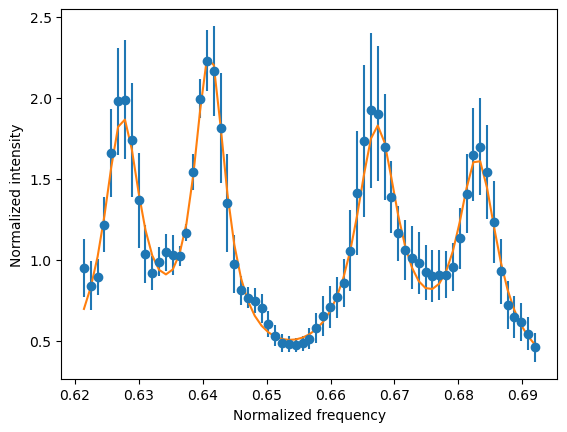

In [11]:
#summary the fitting results
summary = az.summary(simu_idata,round_to=8)
display(summary)

#plot data with the fitting curve
# u11, u20, neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4 = simu_summary['mean'].values
# simu_theta = [u11, u20,neff,ratio, A0, A1, A2, A3, A4, W1,W2,W3,W4]
# model_predictions = fit_curve(freq, theta)
# plt.xlabel("Normalized frequency")
# plt.ylabel("Normalized intensity")
# plt.errorbar(freq, intensity, intensity_sig, fmt = 'o')
# plt.plot(freq, model_predictions);

#plot data with the fitting curve
u11, u20,  e0,de,A0, A1, A2, A3, A4, W1,W2,W3,W4 =summary['mean'].values
theta = [u11, u20,e0,de, A0, A1, A2, A3, A4, W1,W2,W3,W4]
model_predictions = fit_curve(freq, theta)
plt.xlabel("Normalized frequency")
plt.ylabel("Normalized intensity")
plt.errorbar(freq, intensity, intensity_sig, fmt = 'o')
plt.plot(freq, model_predictions);

## py tensor solve nonliear function 

In [30]:
def slabmode2(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
    ###ratio = thickness/lattice constant
    k=np.sqrt(kx**2+ky**2)
    def func(k0):
        return neff**2*np.sqrt( k**2-k0**2 ) -  np.sqrt( (neff**2)*(k0)**2-k**2 ) * np.tan(np.sqrt( (neff**2)*(k0)**2-k**2 )*2*np.pi*ratio)
#     result = fsolve(func, k/neff+0.1)
    
    res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
    return res.x[0]
# def slabmode(kx, ky, neff=1.573, ratio=0.3): ### The authentic waveguide mode, TM0 mode
#     ###ratio = thickness/lattice constant
#     k=pt.sqrt(pt.sqr(kx)+pt.sqr(ky))
#     def func(k0):
#         return pt.sqr(neff)*pt.sqrt(pt.sqr(k)- pt.sqr(k0) ) -  pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))* pt.tan(pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))*2*np.pi*ratio)
# #     result = fsolve(func, k/neff+0.1)
    
#     res = least_squares(func, (k/neff+0.000001), bounds = (k/neff,k))
#     return res.x[0]
def slabmode(kx, ky, neff=1.573, ratio=0.3):
    k=torch.sqrt(kx**2+ky**2)
    res = neff**2*torch.sqrt( k**2-k0**2 ) -  torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)
    return res


In [22]:
DEG = np.pi/180

kx = 0.05
ky = 0
i = 1
Gx = np.array((0.0,1,0,-1))+kx
Gy = np.array((1.0,0,-1,0))+ky
t = slabmode2(-Gx[i],Gy[i])
print(t)

0.7831526714790323


In [12]:
# Gxt = torch.tensor(Gx)
# Gyt = pytensor.shared(Gy)
# n = pytensor.shared(1.5)
# ratio = pytensor.shared(0.3)
# n*np.pi
# #aa = slabmode(Gxt[0],Gyt[0],n,ratio)

Elemwise{mul,no_inplace}.0

In [64]:
torch.tensor([[1., -1.], [1., -1.]])

Gx0 = torch.tensor(Gx[0])
Gy0 = torch.tensor(Gy[0])
k = torch.sqrt(Gx0**2+Gy0**2)
neff  = torch.tensor(1.5)
ratio = torch.tensor(0.3)
k0 =  torch.tensor(0.4,requires_grad=True)
def f(k0):
    return torch.sin(k0) - k0
# def f(k0):
#     return  neff**2*torch.sqrt( k**2-k0**2 ) -  \
# torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)

optimizer = torch.optim.Adam([k0], lr=0.01)

for i in range(6000):
    optimizer.zero_grad()
    loss = f(k0)-5
    loss.backward()
    optimizer.step()
    
print(k0.item())

print(answer)

6.278183460235596
5.0


In [137]:
import torch
from torch.functional import F
n = torch.tensor(0.5, requires_grad=True)
k = torch.tensor(0.5, requires_grad=True)

def f(k,n):
    return k**2 - torch.sin(n*k)

optimizer = torch.optim.LBFGS([k], max_iter=10000, lr=0.0001)

# for i in range(1000):
#     optimizer.zero_grad()
#     output =torch.abs(f(k)) 
#     loss = output
#     loss.backward()
#     optimizer.step()
def closure():
    optimizer.zero_grad()
    output = f(k,n)
    loss = F.mse_loss(output, 0)
    loss.backward()
    guesses.append(weights.clone())
    losses.append(loss.clone())
    return loss
optimizer.step(closure)  
print(k.item())


AttributeError: 'int' object has no attribute 'size'

In [34]:
m = 10+\
14

In [65]:
np.sin(6.27)-6.27


-6.283184925133522

In [120]:
import torch

n = torch.tensor([0.5])
k_guess = torch.tensor([0.01], requires_grad=True)

def equation(k):
    return torch.abs( k- torch.sin(n * k)-0.2)

def slabmode(k0):
    k = 1.05
    neff = 1.5
    ratio  = 0.3
    res = neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)
    return torch.abs(res)

#optimizer = torch.optim.Adam([k_guess], lr=1e-5)
#minimize(equation, k_guess, method[, max_iter, tol, …])
# for i in range(10000):
#     optimizer.zero_grad()
#     loss = equation(k_guess)
#     loss.backward()
#     optimizer.step()
#     if i % 100 == 0:
#         print(f"Iteration {i}: k={k_guess.item():.5f}")
a = torchmin. minimize(slabmode, k_guess, method = 'newton-exact')
# print(f"Final result: k={k_guess.item():.5f}")

In [182]:
### py torch
neff = 1.5
ratio = 0.3
k = 1.05
k0 = np.linspace(1.05/neff,k,100000)
k0 = torch.tensor(k0)
res = torch.abs(neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)) 
aa = torch.min(res)
min_index = torch.argmin(res)
min_k0 = k0[min_index]
print(min_k0)

tensor(0.8141, dtype=torch.float64)


In [200]:
### pytensor
neff = 1.5
ratio = 0.3
k = 1.05
k0 = np.linspace(1.05/neff,k,100000)
k0 =  pytensor.shared(k0)
res = pt.sqr(neff)*pt.sqrt(pt.sqr(k)- pt.sqr(k0)) -  pt.sqrt( pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))* pt.tan(pt.sqrt(pt.sqr(neff)*pt.sqr(k0)-pt.sqr(k))*2*np.pi*ratio)
res = pt.abs(res)
min_index = pt.argmin(res)

min_k0 = k0[min_index]
print(min_k0)
min0 = pt.min(res)
print(min0)
print(k0.get_value)
k0?

Subtensor{int64}.0
Elemwise{neg,no_inplace}.0
<bound method SharedVariable.get_value of <TensorType(float64, (?,))>>


In [172]:
neff = 2.1
ratio = 0.3
k = 1.05
k0 = 0.6094
k0 = torch.tensor(k0)

res = torch.abs(neff**2*torch.sqrt( k**2-k0**2 )-torch.sqrt( (neff**2)*(k0)**2-k**2 ) * torch.tan(torch.sqrt( (neff**2)*(k0)**2-k**2 )*2*pi*ratio)) 
res

tensor(0.0027)

In [174]:
kk = pytensor.shared(0.5)
ham = pytensor.shared(np.zeros((4,4)))
pt.set_subtensor(ham[0,0],kk)

IncSubtensor{Set;int64, int64}.0

In [10]:
import torch

# create a tensor variable with shape (3, 2) filled with random values
x = torch.randn(3, 2)

# create another tensor variable with shape (2, 4) filled with zeros
y = torch.zeros(2, 4)

# perform some operations on the tensors
z = torch.matmul(x, y)

In [12]:
z?